## Exploratory 
### Adapted from Greg's code

In [1]:
.libPaths("/home/jupyter/lib")
library(tidyverse)
library(UpSetR)
library(cowplot)
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}
base_dir <- "../../FH3/flow/"

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## load subject and sample metadata and merge by pbmc_sample_id

In [17]:
# merge in metadata by pbmc_sample_id
subjectmeta<-data.table::fread(paste0(base_dir, "sample_meta_FH3.tsv"))
subjectmeta$pbmc_sample_id<-gsub("_202[0-1].*|.*P[0-9]_","",subjectmeta$file.name)


ERROR: Error in paste0(base_dir, "sample_meta_FH3.tsv"): object 'base_dir' not found


In [3]:
celltype_freq<-read_csv(paste0(base_dir, "PM1_normalized_all_samples_frequency.csv")) %>% rename(pbmc_sample_id = sample_id) %>% mutate(PBID = gsub("-[0-9]*","",pbmc_sample_id))

New names:
* ...3 -> ...12

Rows: 4101 Columns: 12

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sample_id, FlowSOM_meta_spe_anno, batch, sample_type, Population
dbl (3): N, freq_live, FlowSOM_meta_spe
lgl (4): Singlet, Viable, Viable_label_adjusted, ...12


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [4]:
subjectmeta <- subjectmeta %>% mutate(PBID = gsub("-[0-9]*","",pbmc_sample_id))

In [5]:
celltype_freq_meta <- left_join(celltype_freq,subjectmeta,by = "PBID")

In [6]:
colnames(celltype_freq_meta)

[1] "pbmc_sample_id.x"           "FlowSOM_meta_spe_anno"     
 [3] "N"                          "freq_live"                 
 [5] "Singlet"                    "Viable"                    
 [7] "Viable_label_adjusted"      "batch"                     
 [9] "sample_type"                "Population"                
[11] "FlowSOM_meta_spe"           "...12"                     
[13] "PBID"                       "subject.subjectGuid"       
[15] "file.id"                    "file.name"                 
[17] "Sex"                        "Race"                      
[19] "Ethnicity"                  "Birth.Year"                
[21] "sample.visitName"           "Batch"                     
[23] "sample.sampleKitGuid"       "sample.drawDate"           
[25] "Cohort"                     "sample.visitDetails"       
[27] "sample.daysSinceFirstVisit" "Visit"                     
[29] "SampleDraw"                 "Is_Flu"                    
[31] "VisitYearSequence"          "FluYear"                   
[33] "FluVisit"                   "Day"                       
[35] "hasD0D7"                    "hasD0D7D90"                
[37] "selected_for_analysis"      "pbmc_sample_id.y"

In [8]:
## select debris clusters to remove from dataset.
remove_debris<-grep("debris",unique(celltype_freq_meta$FlowSOM_meta_spe_anno),value=T)

In [12]:
celltype_freq_meta <-celltype_freq_meta %>% filter(sample_type == "sample" & !(FlowSOM_meta_spe_anno %in% remove_debris)) %>% group_by(subject.subjectGuid,FlowSOM_meta_spe_anno,Day) %>% mutate(avg = mean(freq_live)) %>%arrange(FlowSOM_meta_spe_anno) %>% group_by(subject.subjectGuid,FlowSOM_meta_spe_anno) %>% 
arrange(Day) %>% mutate(d0FC = avg/avg[1])

`summarise()` has grouped output by 'FlowSOM_meta_spe_anno'. You can override using the `.groups` argument.



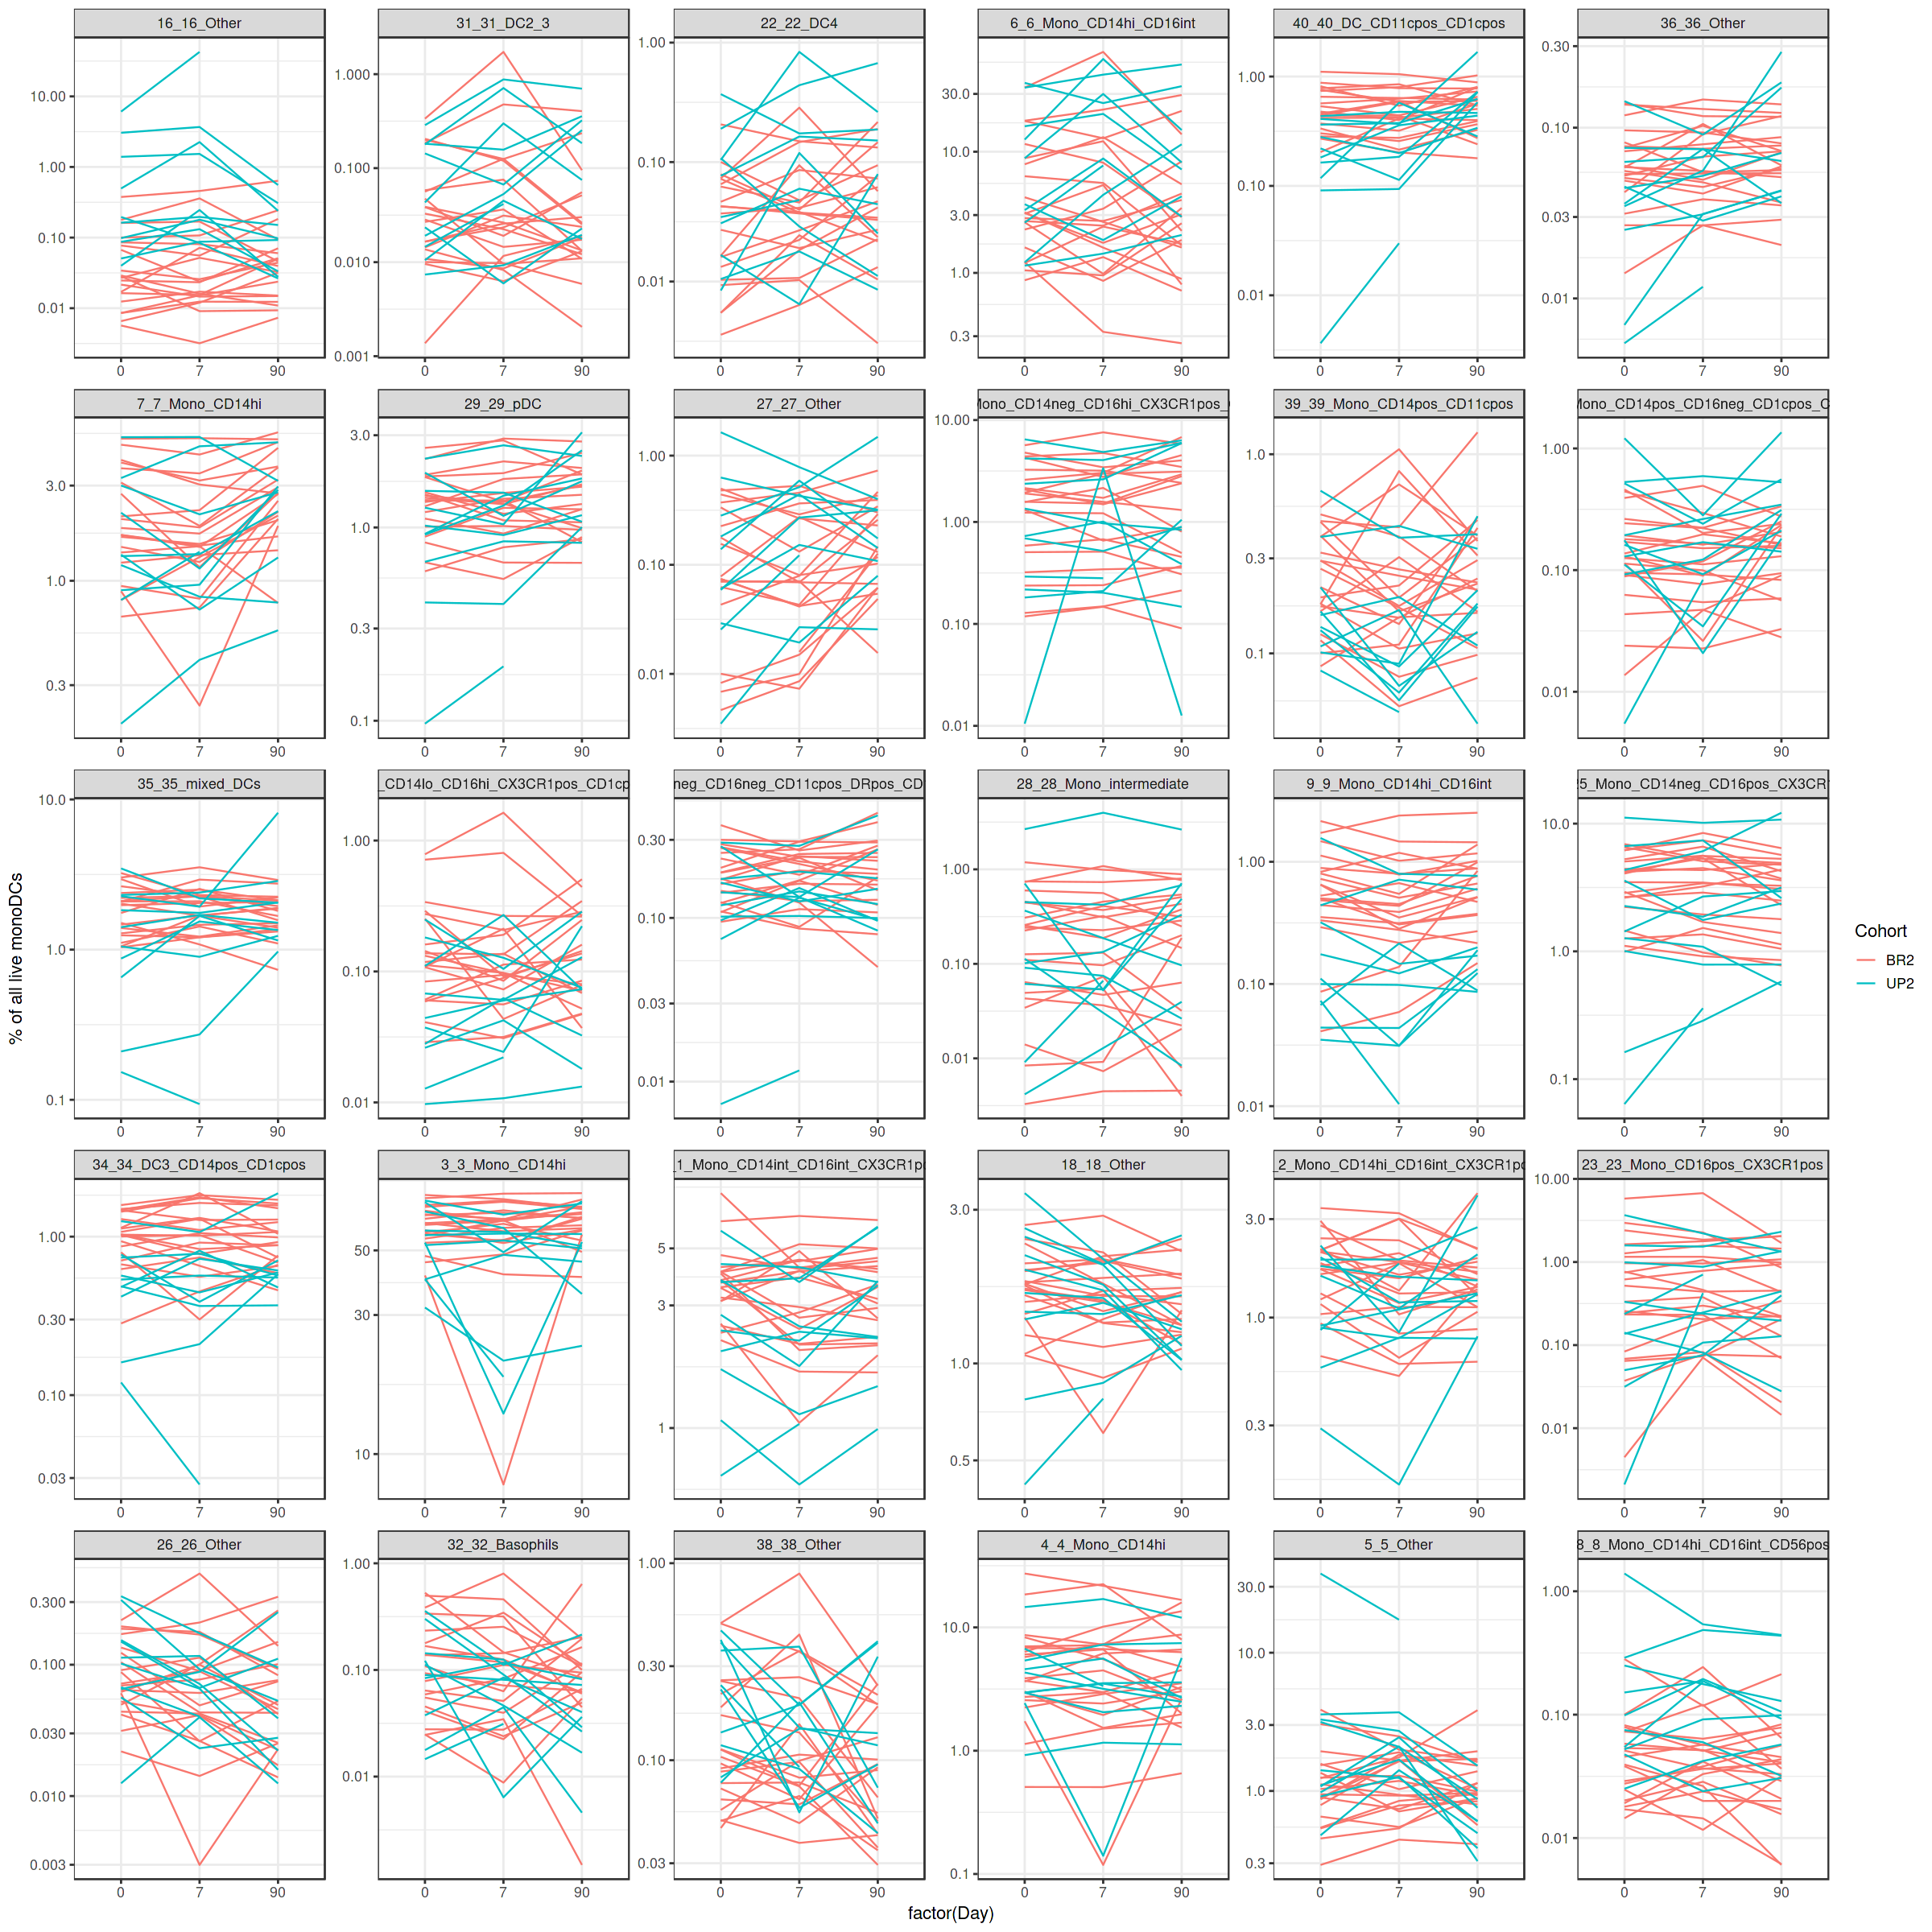

In [22]:
fig.size(20,20)

cluster_relevel <- celltype_freq_meta %>% group_by(FlowSOM_meta_spe_anno,Day) %>% summarise(day_avg = mean(freq_live)) %>% mutate(d0FC = day_avg/day_avg[1]) %>% arrange(-d0FC) %>% pull(FlowSOM_meta_spe_anno) %>% unique
celltype_freq_meta$FlowSOM_meta_spe_anno<- factor(x=celltype_freq_meta$FlowSOM_meta_spe_anno,levels = cluster_relevel)

ggplot(celltype_freq_meta,aes(x=factor(Day),y=freq_live*100)) + 
geom_line(mapping = aes(group = subject.subjectGuid,color=Cohort)) +
scale_y_log10() + facet_wrap(~FlowSOM_meta_spe_anno,scales="free",labeller = label_wrap_gen(width = 25,multi_line = TRUE)) + theme_bw(base_size = 13) + ylab("% of all live monoDCs")

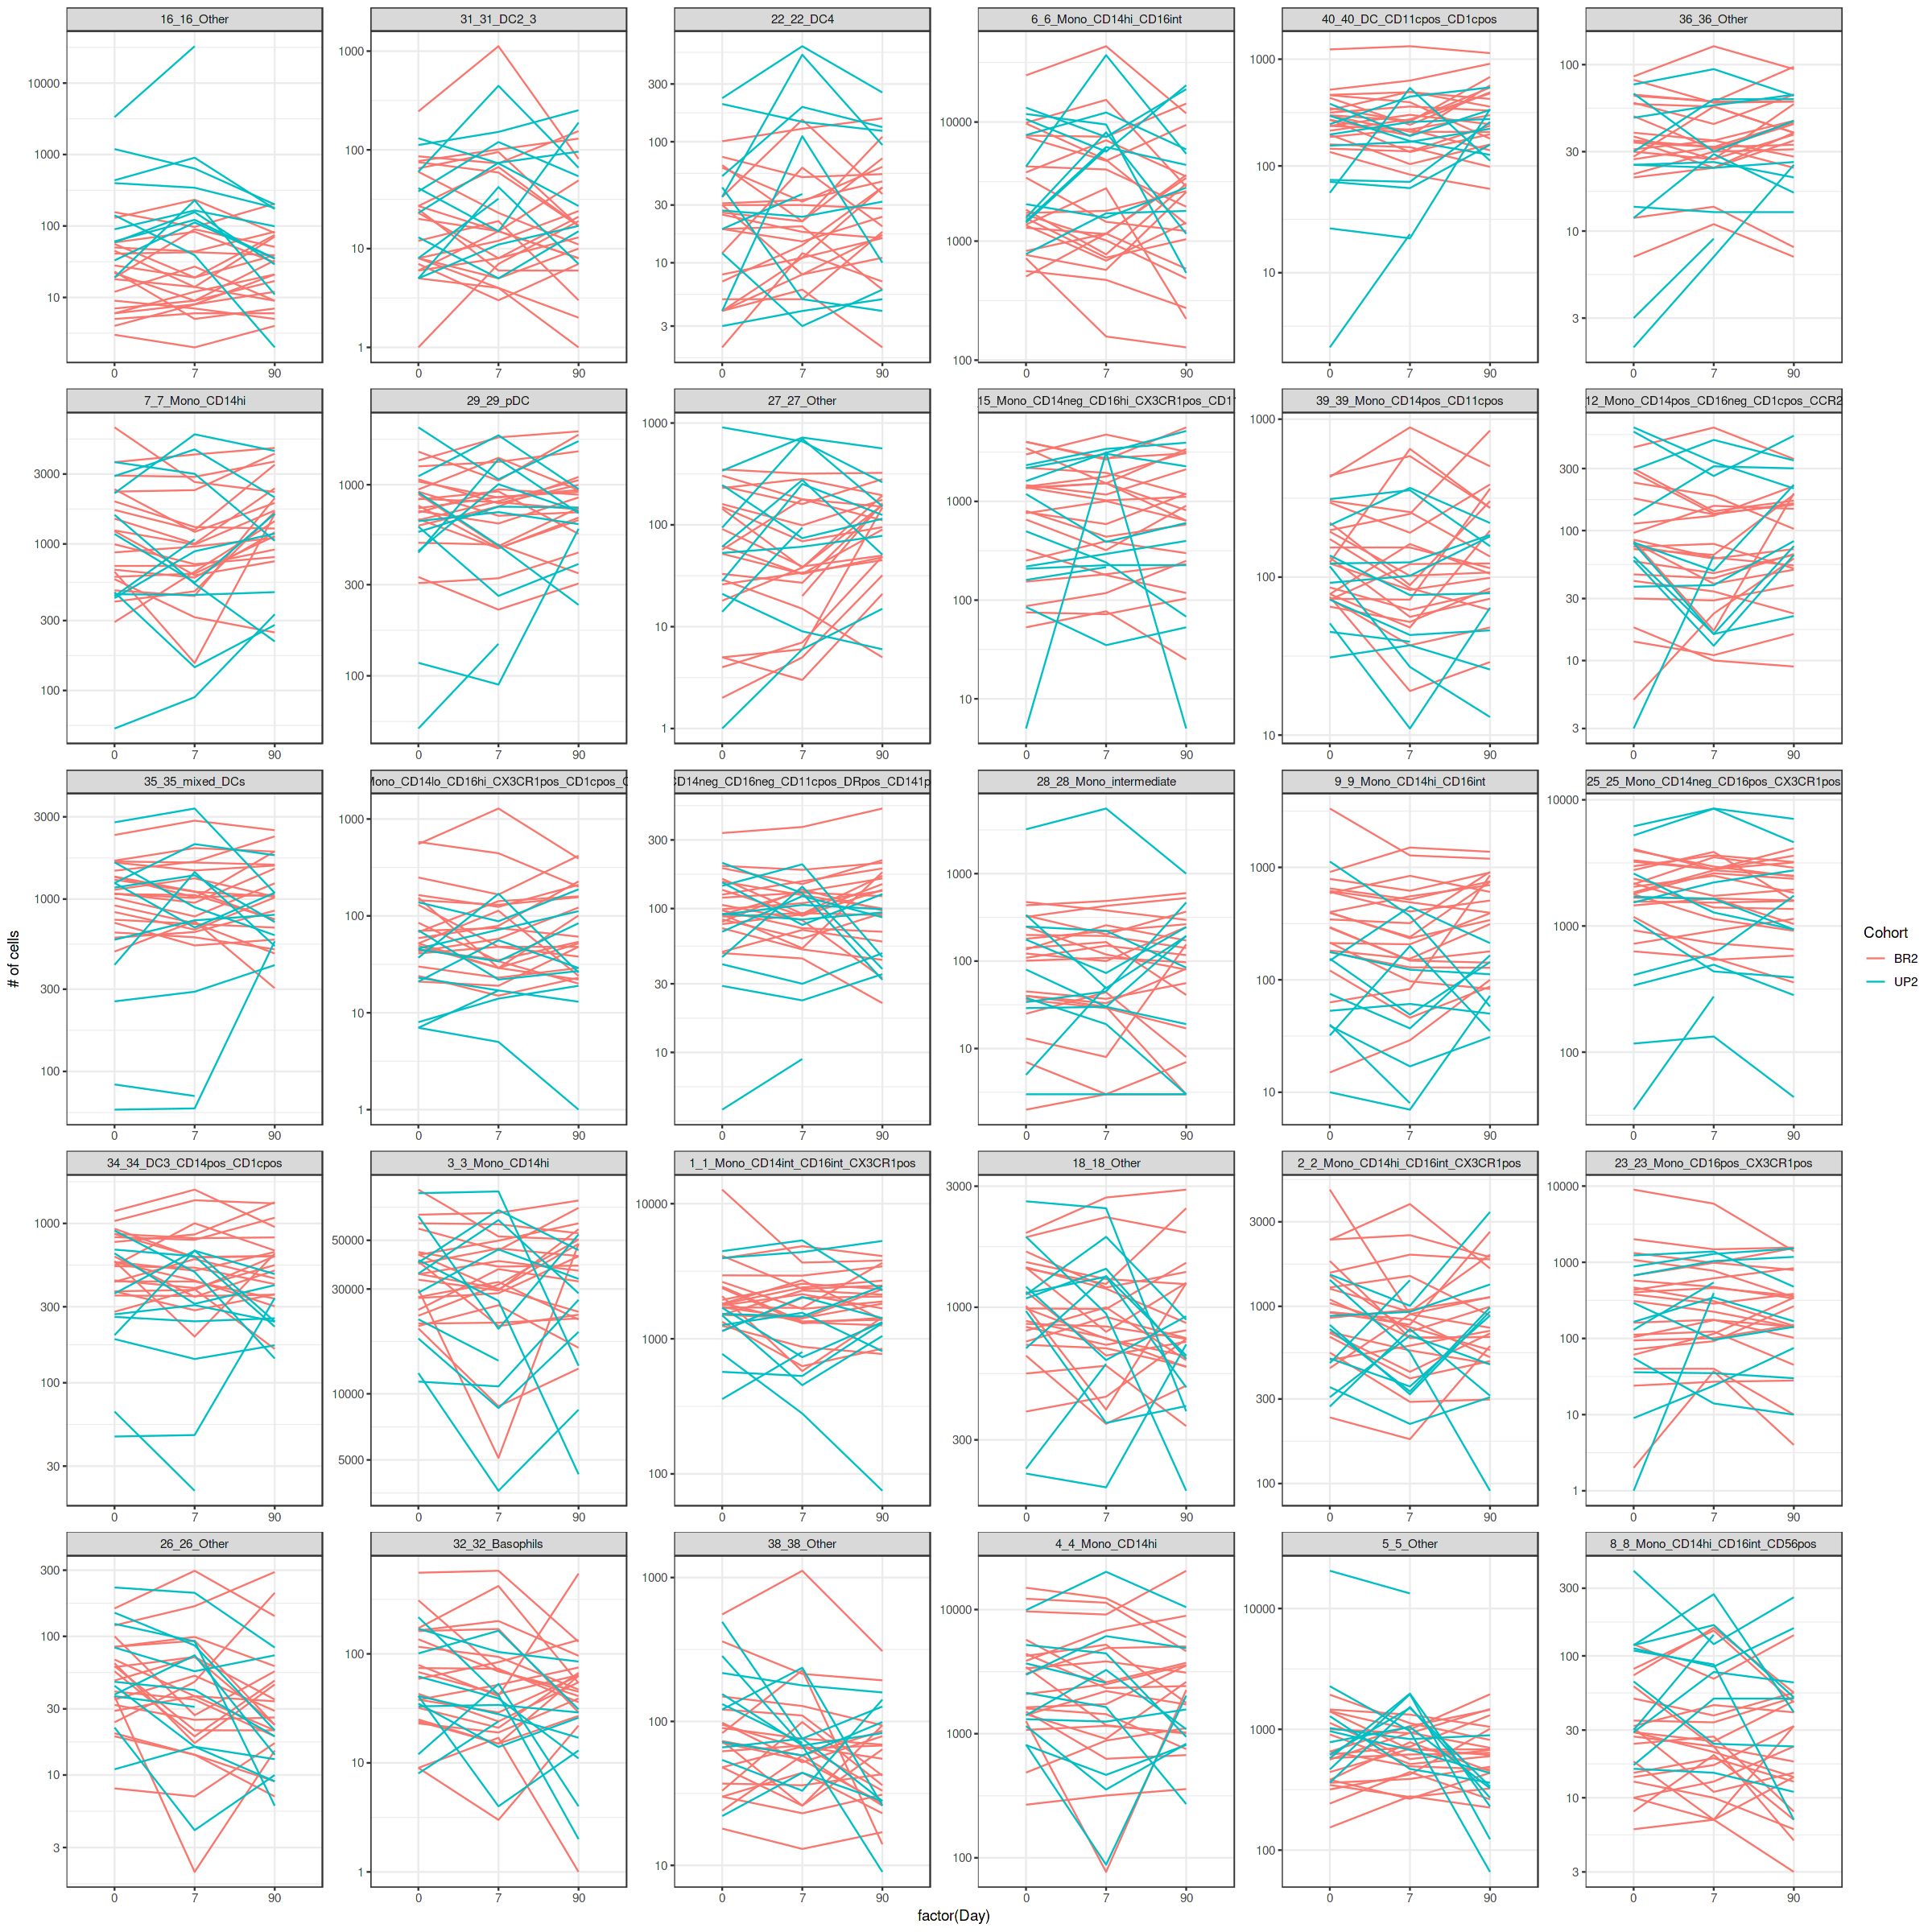

In [23]:
fig.size(20,20)
ggplot(celltype_freq_meta,aes(x=factor(Day),y=N)) + 
geom_line(mapping = aes(group = subject.subjectGuid,color=Cohort)) +
scale_y_log10() + facet_wrap(~FlowSOM_meta_spe_anno,scales="free") + theme_bw() + ylab("# of cells")

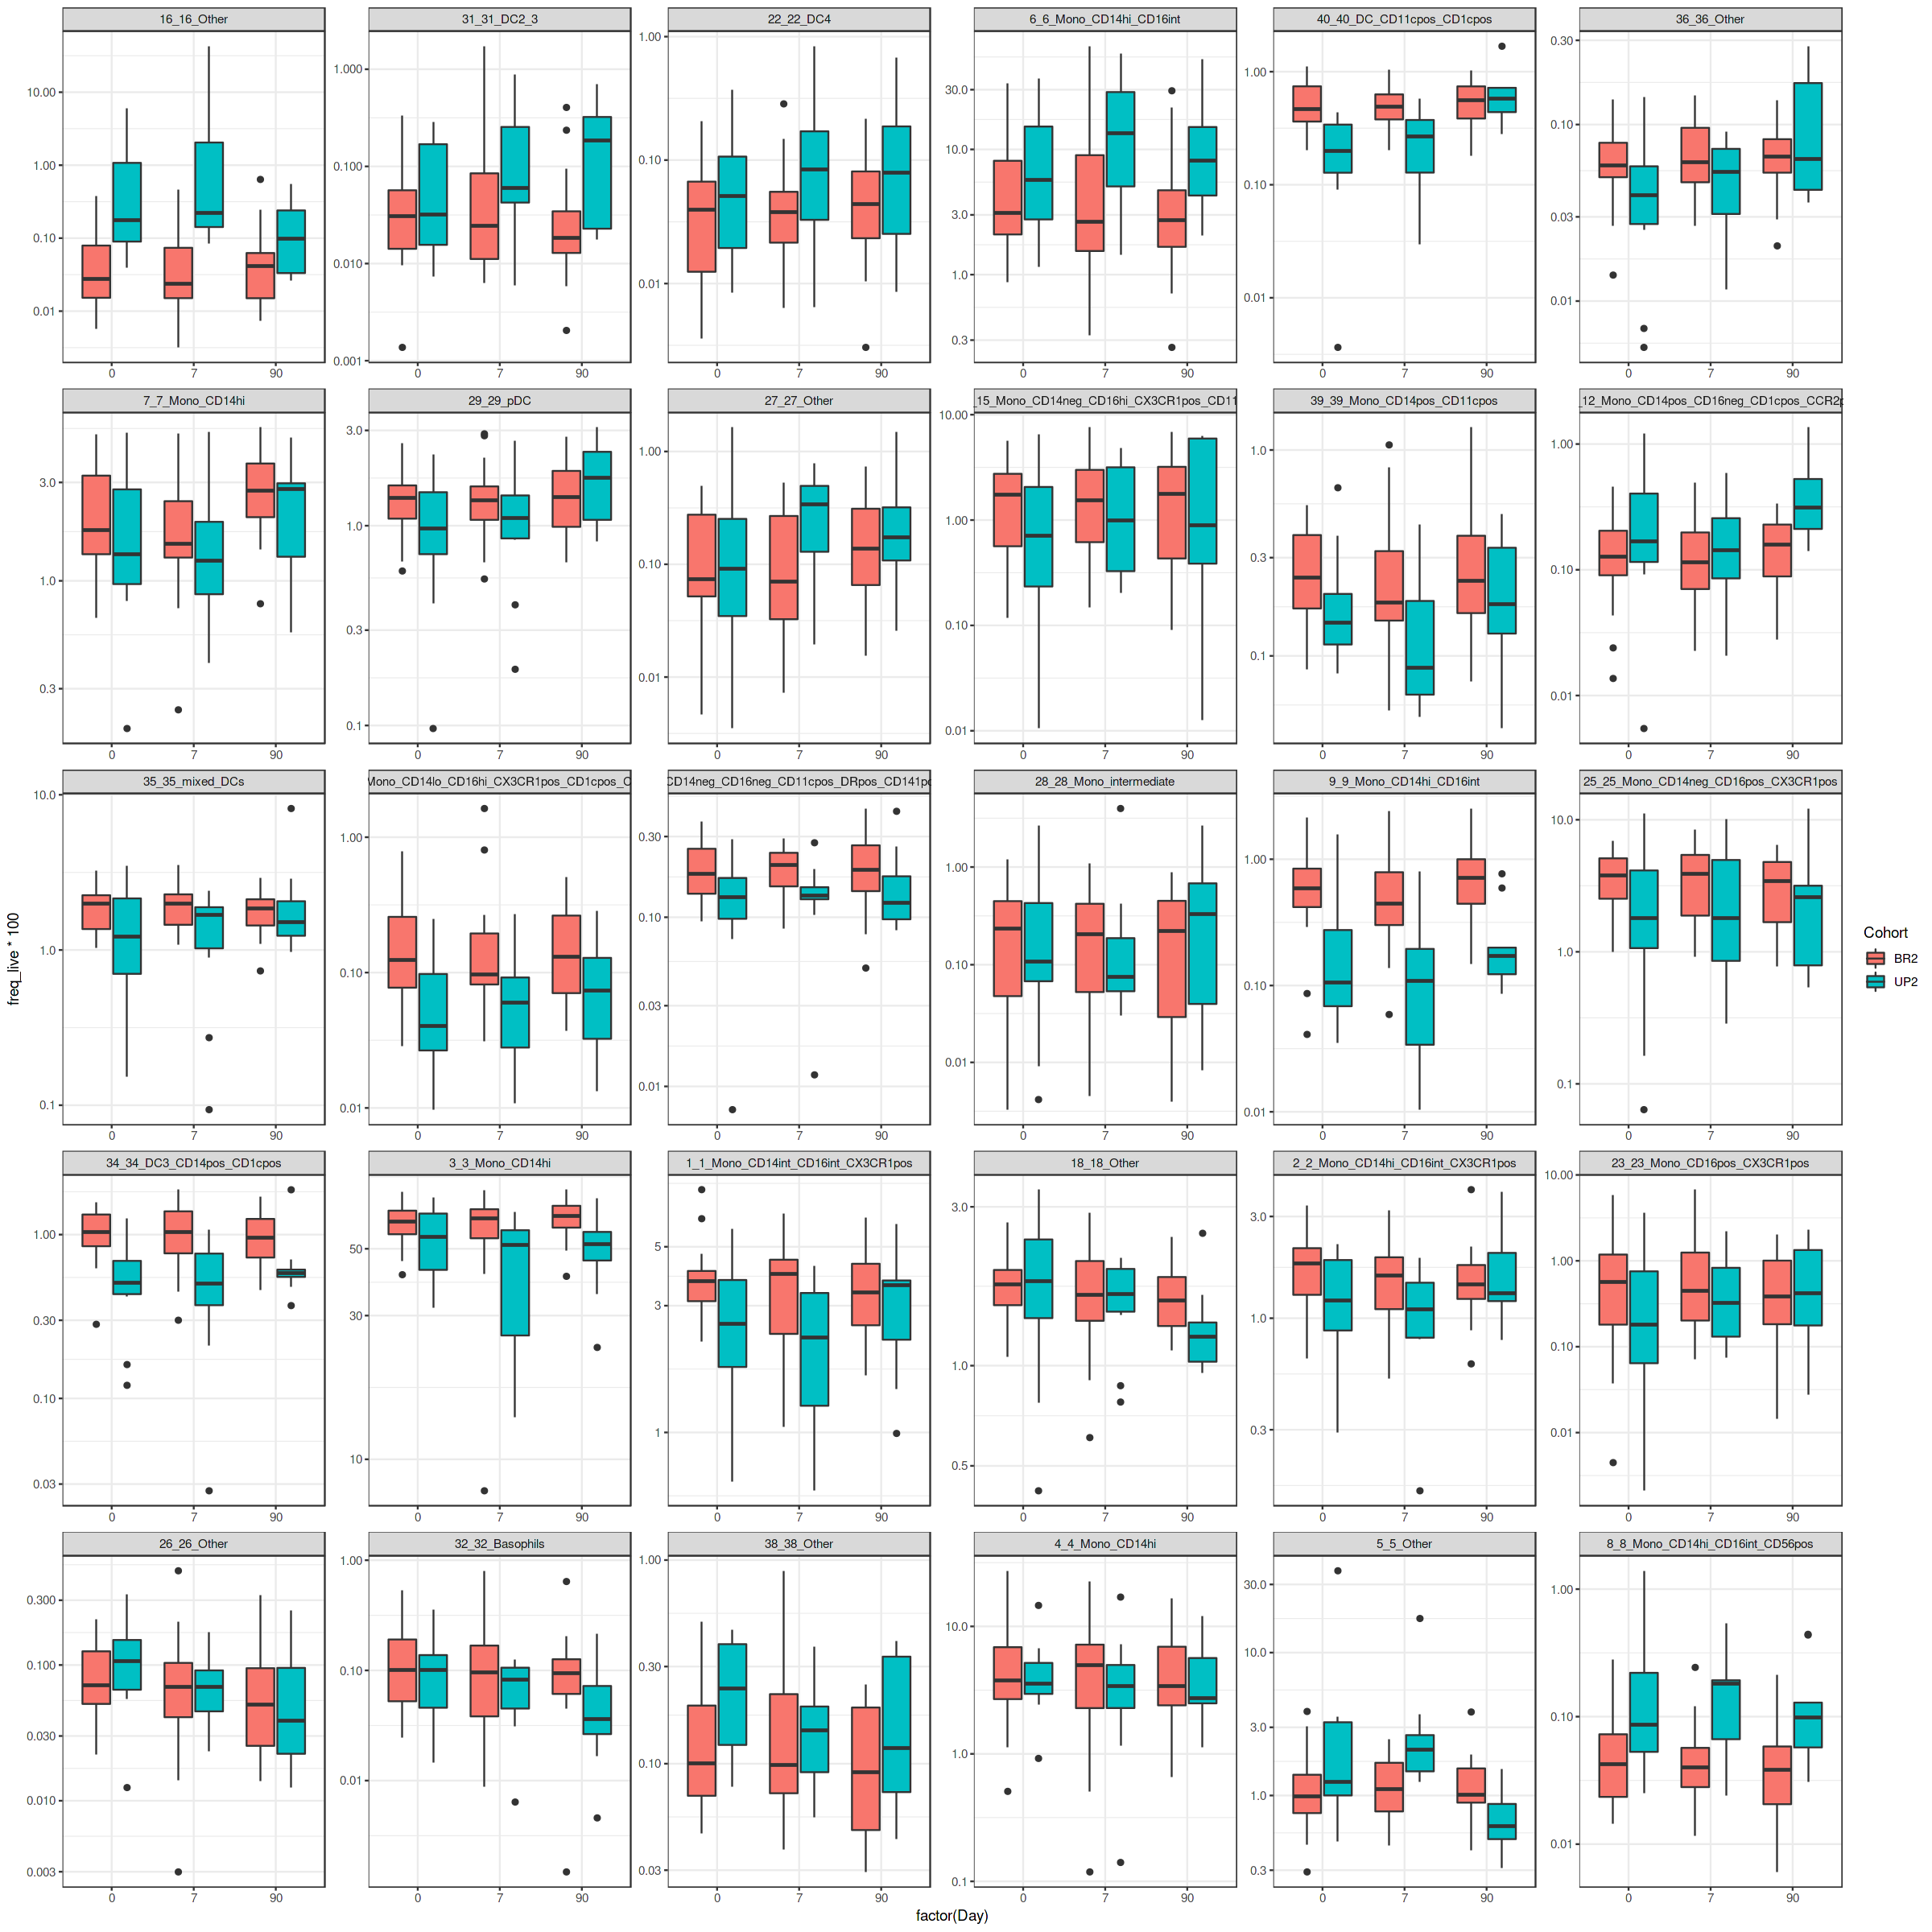

In [25]:
ggplot(celltype_freq_meta %>% filter(sample_type == "sample"),aes(x=factor(Day),y=freq_live*100)) + 
geom_boxplot(mapping = aes(fill=Cohort)) +
scale_y_log10() + facet_wrap(~FlowSOM_meta_spe_anno,scales="free") + theme_bw()

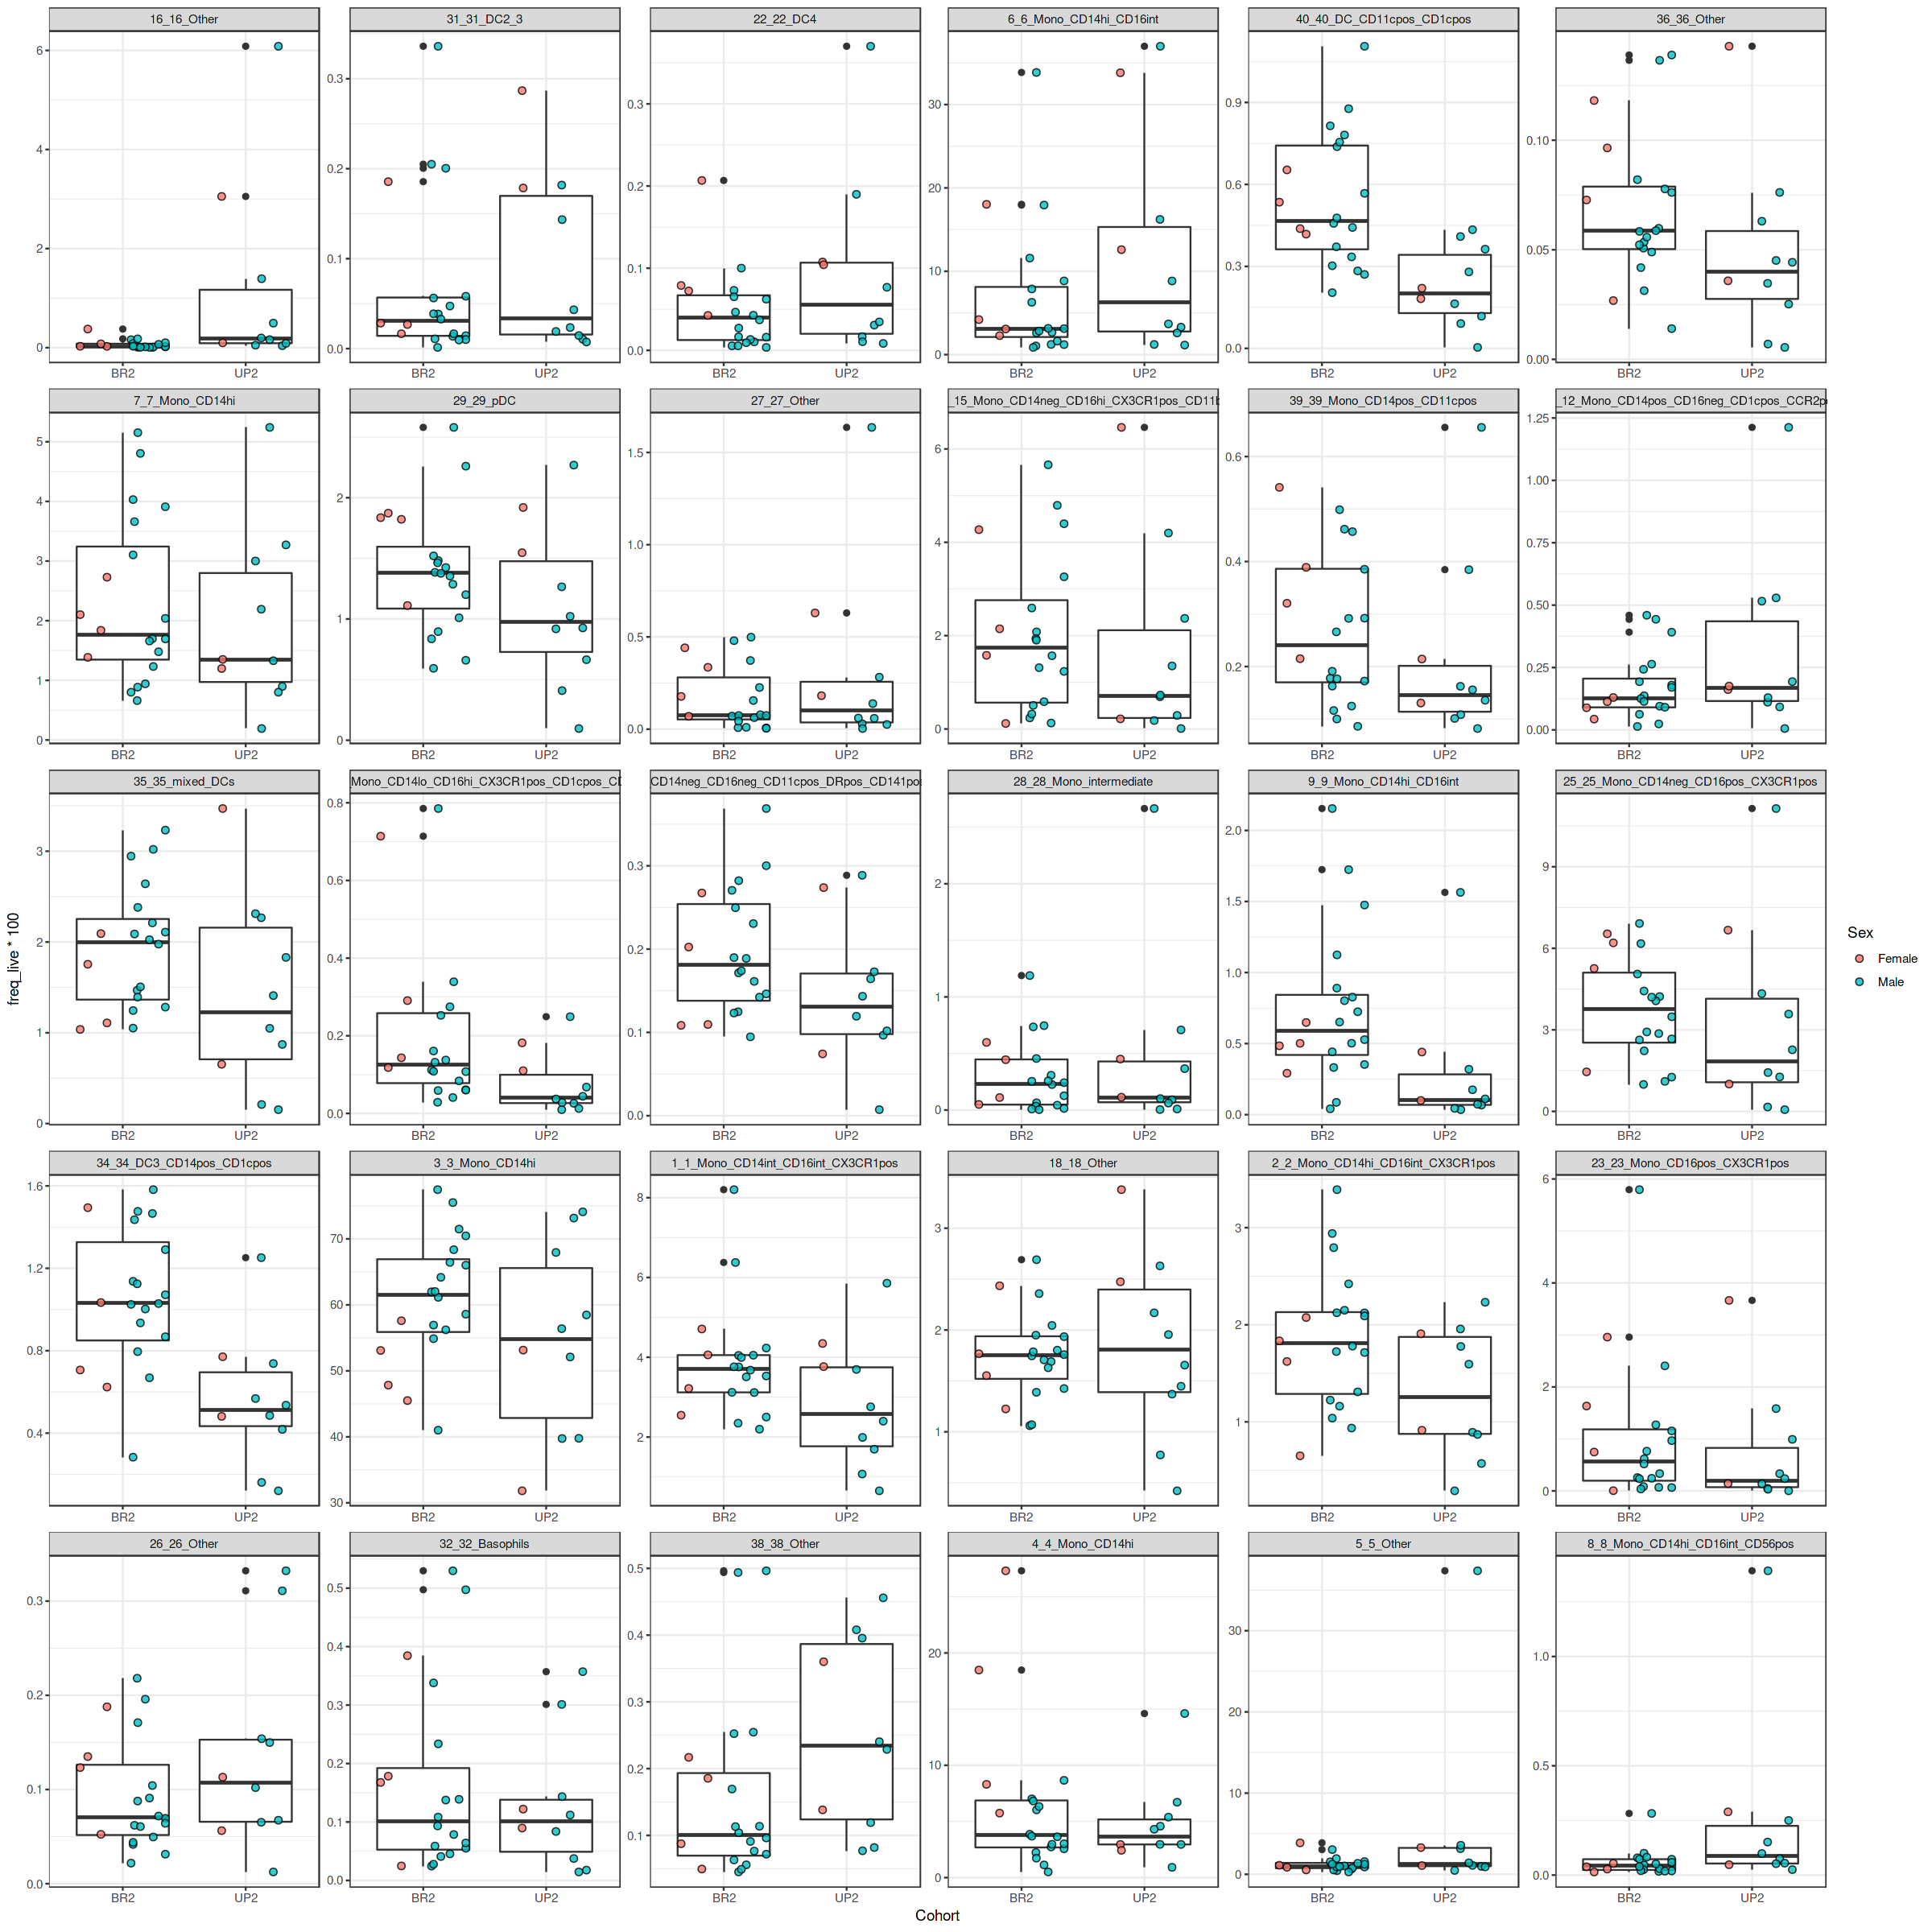

In [26]:
ggplot(celltype_freq_meta %>% filter(sample_type == "sample" & Day == 0),aes(x=Cohort,y=freq_live*100)) + 
geom_boxplot() +
    geom_jitter(mapping = aes(fill=Sex),shape=21,position = position_jitterdodge(jitter.width = .3,dodge.width = .8),alpha=.8,size=2) + 
 facet_wrap(~FlowSOM_meta_spe_anno,scales="free") + theme_bw()

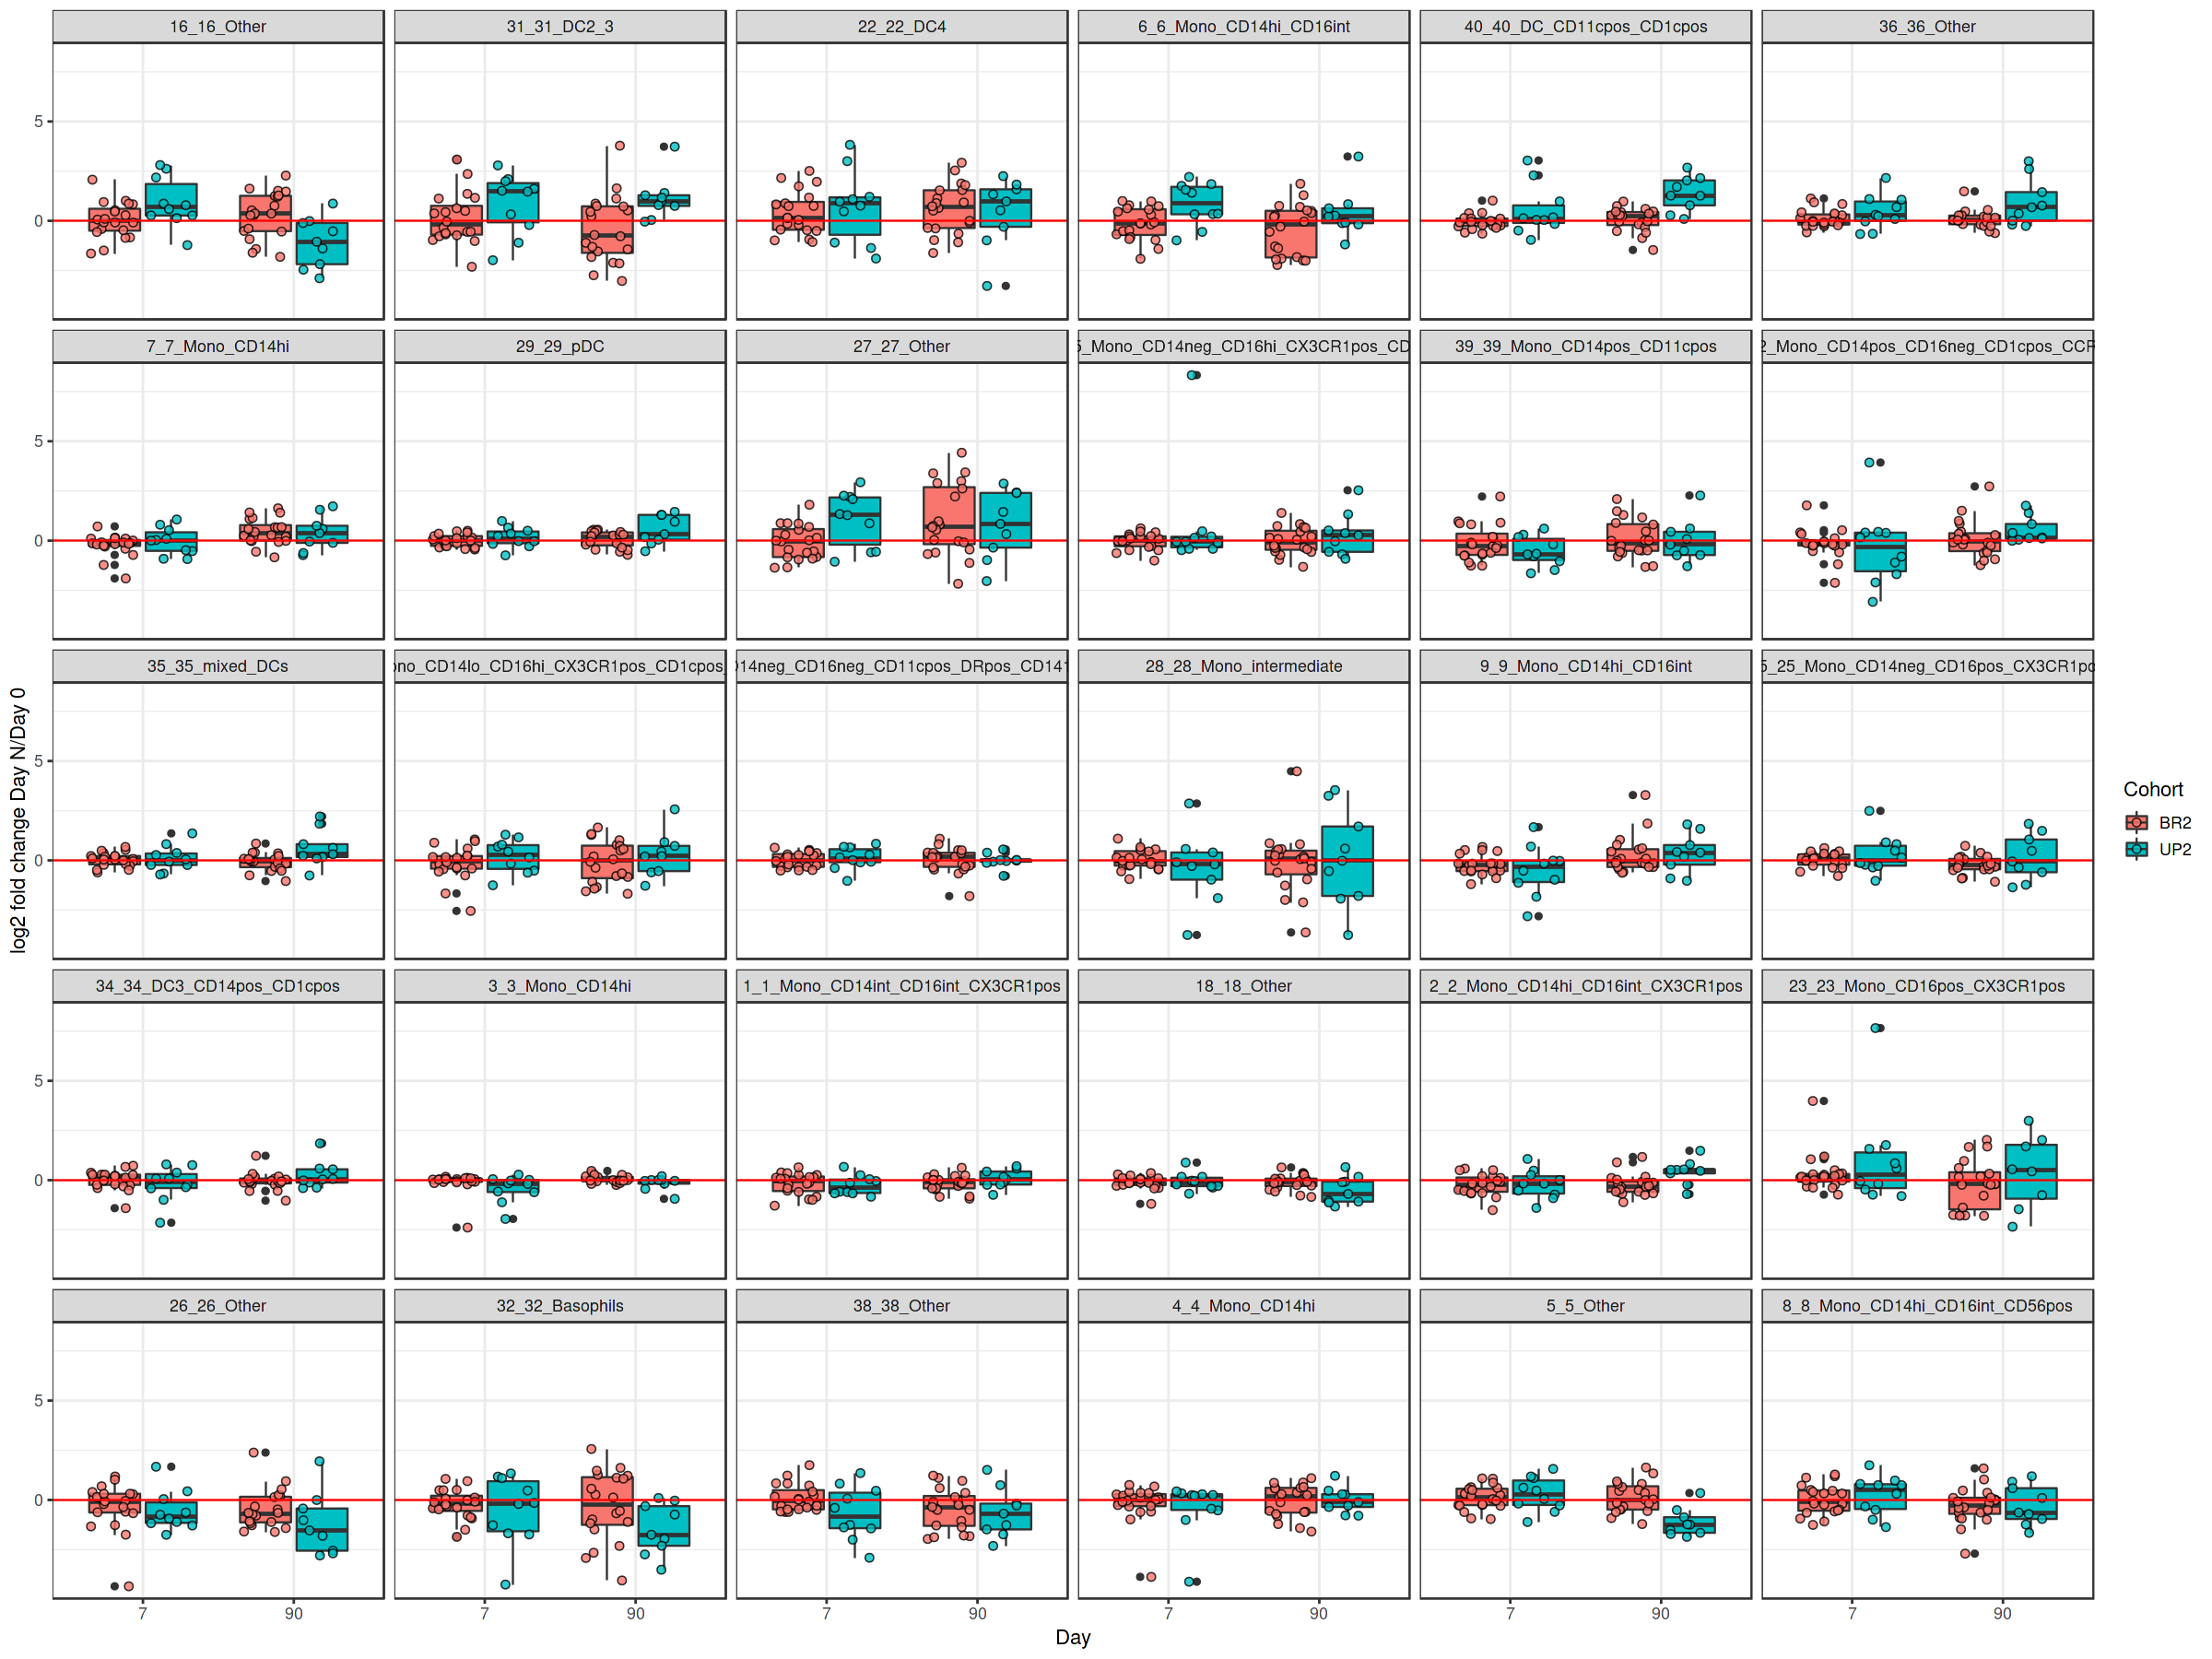

In [27]:
fig.size(15,20)
plotdata <- celltype_freq_meta %>% filter(sample_type == "sample" & Day %in% c(7,90)) 

ggplot(plotdata,aes(x=factor(Day),y=log2(d0FC),fill=Cohort)) + 
geom_boxplot() + 
    geom_jitter(shape=21,position = position_jitterdodge(jitter.width = .3,dodge.width = .8),alpha=.8,size=2) + geom_hline(yintercept = 0,color="red") +
facet_wrap(~FlowSOM_meta_spe_anno,labeller = label_wrap_gen(width = 30,multi_line = TRUE)) + theme_bw(base_size = 13) + ylab("log2 fold change Day N/Day 0") + xlab("Day")

In [30]:
pullclusters <- unique(grep("^16|^31|^6|22|27",celltype_freq_meta$FlowSOM_meta_spe_anno,value = T))

In [ ]:
fig.size(10,12)
plotdata <- celltype_freq_meta %>% filter(sample_type == "sample" &  FlowSOM_meta_spe_anno %in% pullclusters) 

p<-ggplot(plotdata,aes(x=factor(Day),y=log2(d0FC))) + 
    geom_line(mapping = aes(color=Cohort,group = subject.subjectGuid),alpha=.5) + geom_smooth(mapping = aes(color=Cohort,group=Cohort),na.rm = T,se = F,size=3,linetype="longdash") + geom_hline(yintercept = 0,color="black") +
facet_wrap(~FlowSOM_meta_spe_anno,scales="free", labeller = label_wrap_gen(width = 30,multi_line = TRUE)) + theme_bw(base_size = 12) + ylab("log2 fold change Day N/Day 0") + xlab("Day")
suppressWarnings(print(p))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



In [20]:
unique(plotdata$subject.subjectGuid)

[1] "BR2010" "BR2003" "BR2015" "BR2007" "BR2022" "BR2012" "BR2023" "UP2012"
 [9] "UP2015" "BR2028" "BR2030" "BR2038" "BR2037" "BR2031" "UP2003" "UP2002"
[17] "BR2025" "BR2039" "BR2047" "BR2048" "BR2049" "BR2020" "BR2021" "BR2019"
[25] "UP2006" "UP2007" "UP2005" "UP2011" "UP2009" "UP2001"

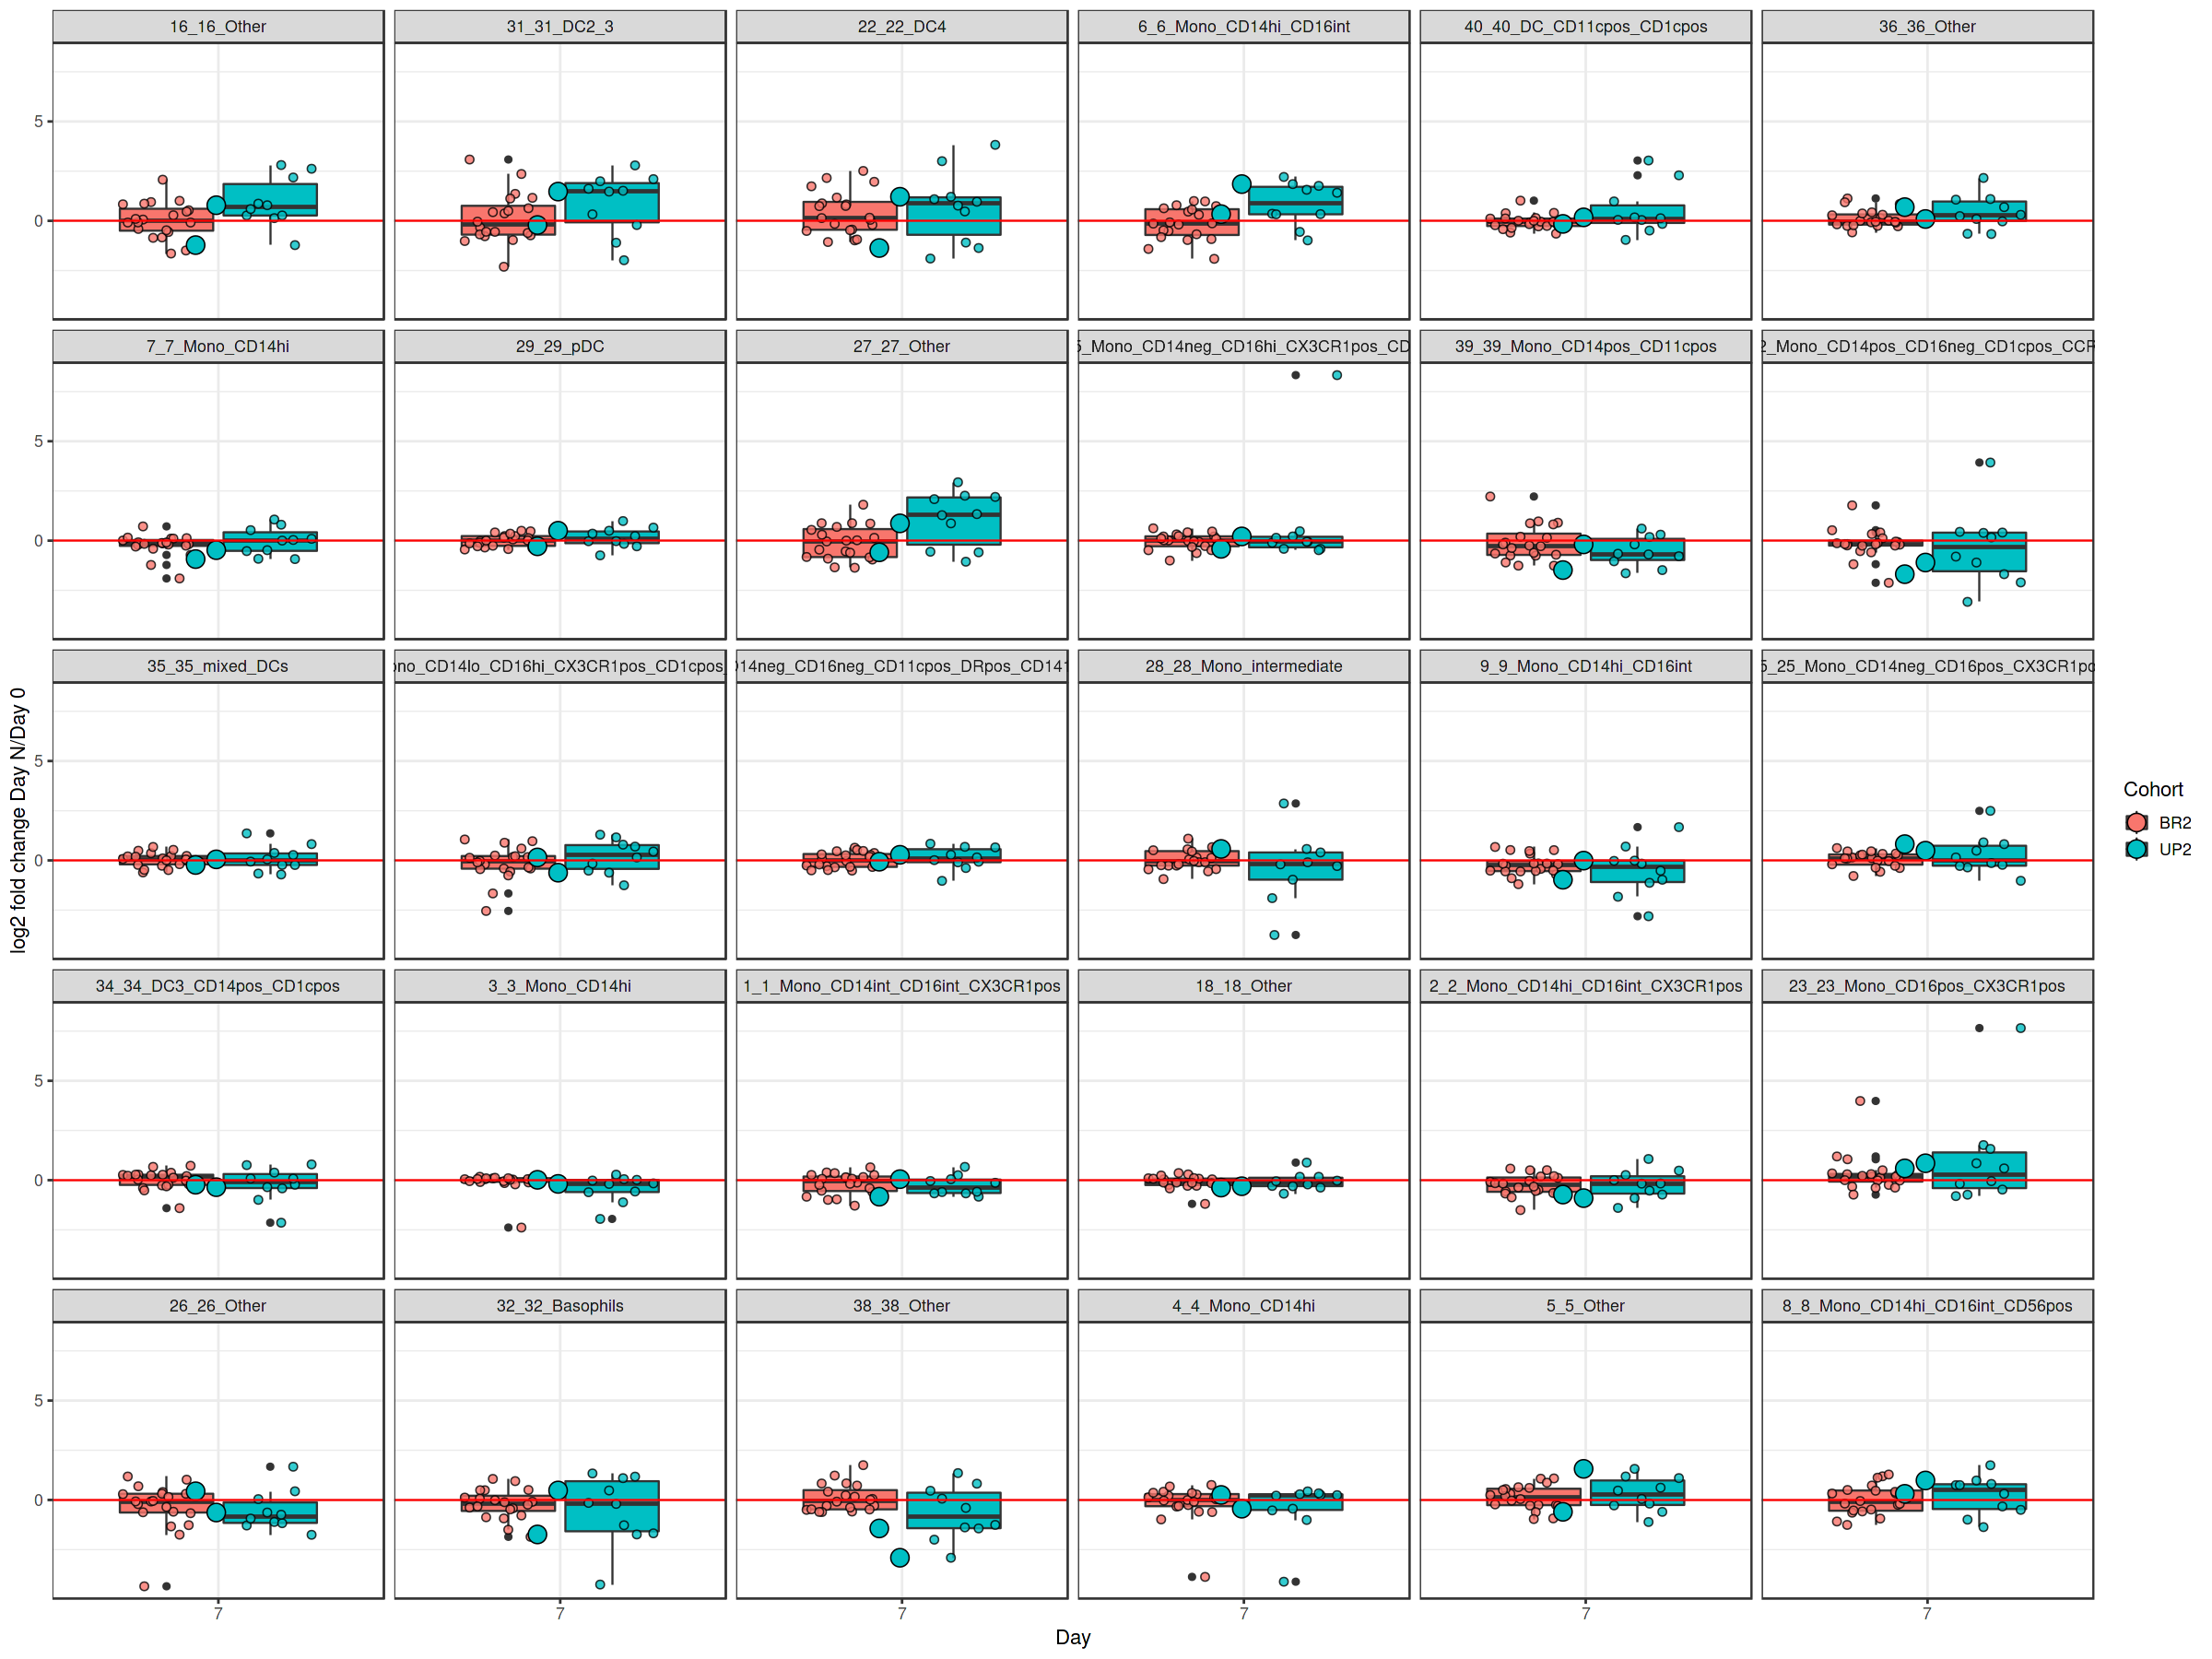

In [21]:
fig.size(15,20)
plotdata <- celltype_freq_meta %>% filter(sample_type == "sample" & Day %in% c(7)) 

ggplot(plotdata,aes(x=factor(Day),y=log2(d0FC),fill=Cohort)) + 
geom_boxplot() + 
    geom_jitter(shape=21,position = position_jitterdodge(jitter.width = .3,dodge.width = .8),alpha=.8,size=2) + 
    geom_jitter(plotdata %>% filter(subject.subjectGuid %in% c("UP2001","UP2017","UP2012","UP2018")),mapping = aes(x=factor(Day),y=log2(d0FC),fill=Cohort),shape=21,position = position_jitterdodge(jitter.width = .3,dodge.width = .8),size=5) + geom_hline(yintercept = 0,color="red") +
facet_wrap(~FlowSOM_meta_spe_anno,labeller = label_wrap_gen(width = 30,multi_line = TRUE)) + theme_bw(base_size = 13) + ylab("log2 fold change Day N/Day 0") + xlab("Day")